<a href="https://colab.research.google.com/github/zainulabidin73622/DEEP_LEARNING/blob/main/OEL(DL)0052_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Install required packages

In [2]:
!pip install kaggle opendatasets --quiet

Import Dataset From Kaggle

In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


 Download the Intel Image Classification dataset

In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

Import necessary libraries

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

 Prepare dataset paths

In [5]:
train_dir = '/content/seg_train/seg_train'
test_dir = '/content/seg_test/seg_test'

# Check the classes
class_names = os.listdir(train_dir)
print("Class names:", class_names)

Class names: ['buildings', 'sea', 'mountain', 'glacier', 'street', 'forest']


 Data augmentation and preprocessing

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # Using 20% for validation

test_datagen = ImageDataGenerator(rescale=1./255)

# Adjust batch size according to your GPU memory
batch_size = 32
img_size = 160  # MobileNetV2 works well with 160x160

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Create MobileNetV2 base model

In [7]:
base_model = MobileNetV2(input_shape=(img_size, img_size, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Build custom model on top

In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')  # 6 classes
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Train the model

In [9]:
epochs = 15

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 115s 297ms/step - accuracy: 0.5631 - loss: 1.1653 - val_accuracy: 0.8610 - val_loss: 0.4040
Epoch 2/15
  1/350 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.7500 - loss: 0.5881

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.7500 - loss: 0.5881 - val_accuracy: 0.8527 - val_loss: 0.3982
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 143s 370ms/step - accuracy: 0.8234 - loss: 0.4851 - val_accuracy: 0.8693 - val_loss: 0.3747
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.8125 - loss: 0.5457 - val_accuracy: 0.8693 - val_loss: 0.3725
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 203s 430ms/step - accuracy: 0.8458 - loss: 0.4183 - val_accuracy: 0.8743 - val_loss: 0.3479
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.8750 - loss: 0.3435 - val_accuracy: 0.8703 - val_loss: 0.3583
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 128s 270ms/step - accuracy: 0.8478 - loss: 0.4031 - val_accuracy: 0.8847 - val_loss: 0.3307
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8438 - loss: 0.4695 - val_accuracy: 0.8779 - val_loss: 0.3263
Epoch 9/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 142s 322ms/step - accuracy: 0.8565 - loss: 0.3845 - val

Fine-tuning

In [10]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train for a few more epochs
fine_tune_epochs = 2
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

Epoch 15/17
350/350 ━━━━━━━━━━━━━━━━━━━━ 151s 333ms/step - accuracy: 0.7207 - loss: 0.7772 - val_accuracy: 0.8696 - val_loss: 0.3625
Epoch 16/17
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8750 - loss: 0.3655 - val_accuracy: 0.8664 - val_loss: 0.3715
Epoch 17/17
350/350 ━━━━━━━━━━━━━━━━━━━━ 97s 277ms/step - accuracy: 0.8321 - loss: 0.4484 - val_accuracy: 0.8671 - val_loss: 0.3749


Evaluate the model

In [11]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']



Evaluation on test set

In [12]:
final_train_acc = history.history['accuracy'][-1]
print(f"\n Training Accuracy: {final_train_acc*100:.2f}%")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')




 Training Accuracy: 87.51%
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8736 - loss: 0.3252
Test Accuracy: 87.77%


Display some prediction

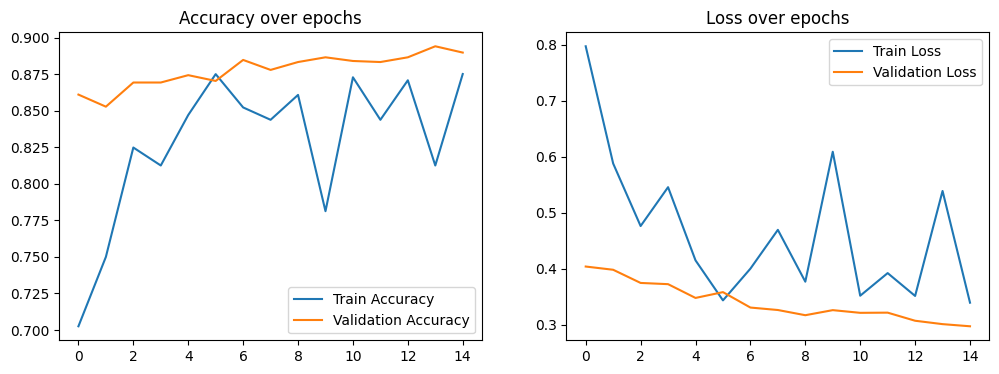

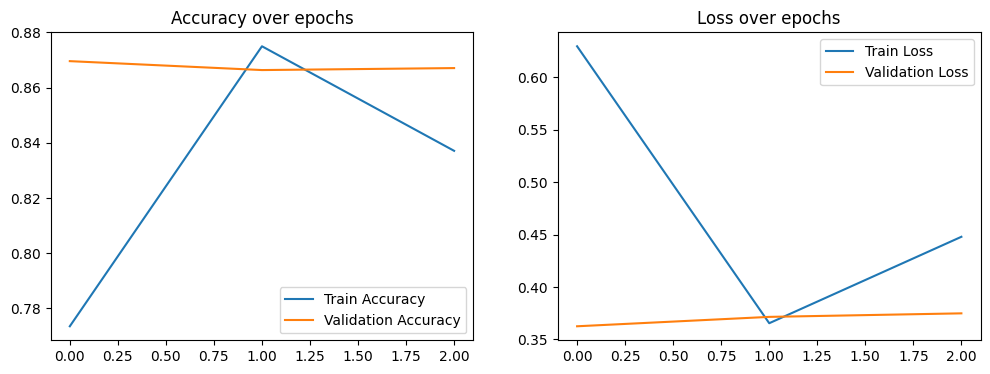

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


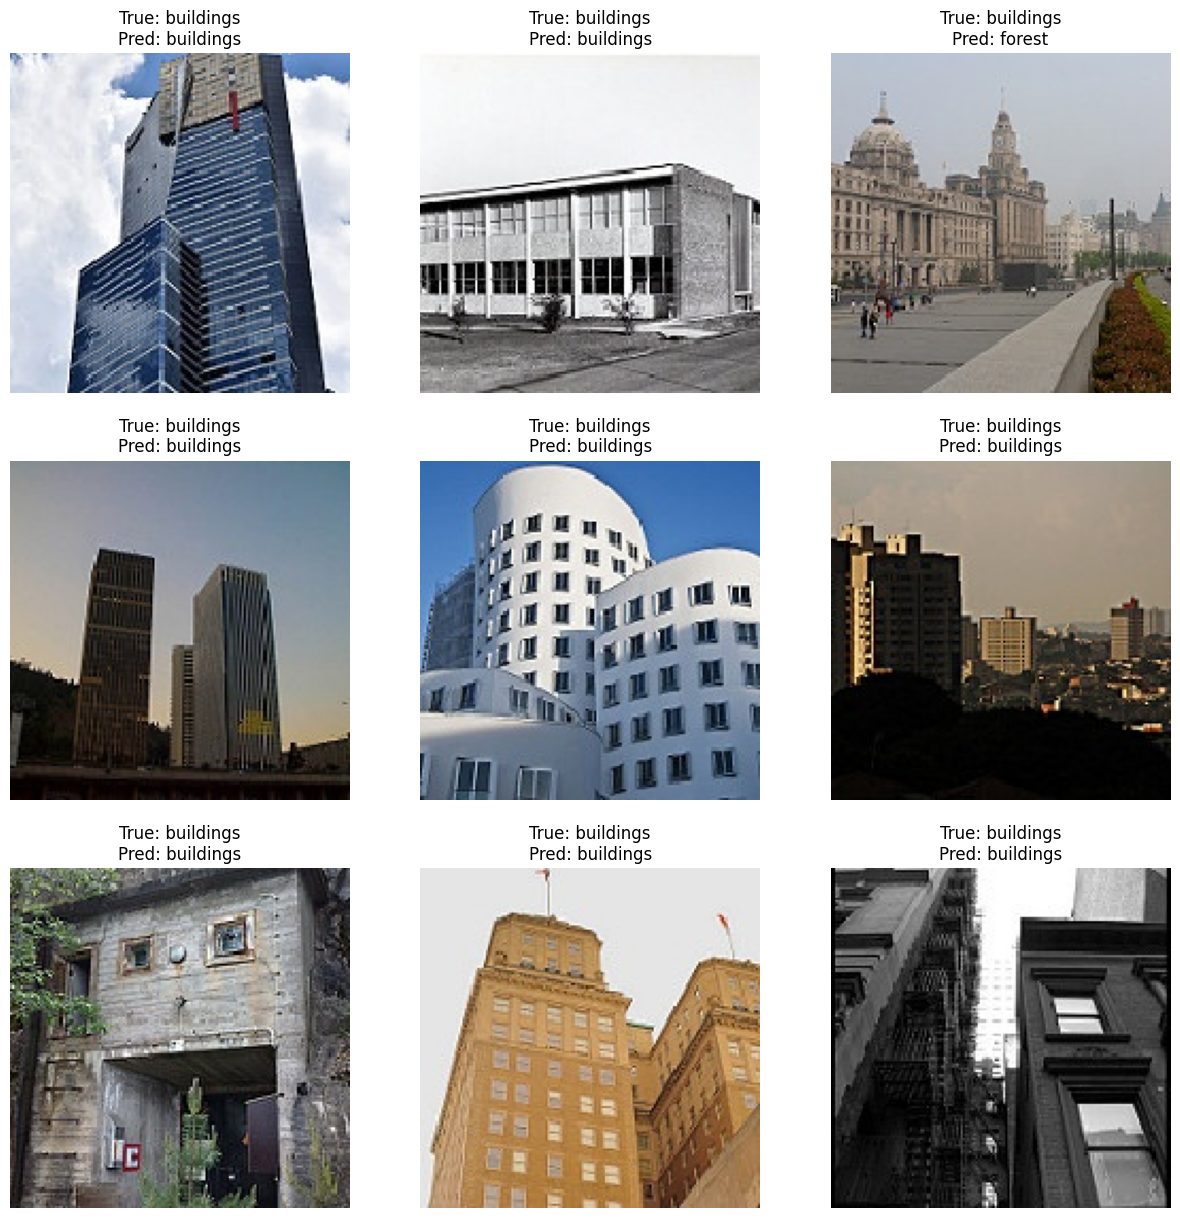

In [13]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.legend()

    plt.show()

plot_history(history)
if 'history_fine' in locals():
    plot_history(history_fine)

# Display some predictions
plt.figure(figsize=(15, 15))
# Use iter() to create an iterator from the generator
test_iter = iter(test_generator)
for i in range(9):
    plt.subplot(3, 3, i+1)
    # Use next() to get the next batch
    img, label = next(test_iter)
    # Since we're getting a batch, predict on the first image in the batch
    pred_label = class_names[np.argmax(model.predict(img[0:1]))]
    # The label is one-hot encoded for the batch, so get the true label for the first image
    true_label = class_names[np.argmax(label[0])]

    plt.imshow(img[0])
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()